# Multiple bodies

Under the hood, the cache uses the concept of a `Body` (from the `RigidBodyTools.jl` package)
to perform certain
calculations, like normal vectors and surface panel areas, which may
specialize depending on the type of body shape. Note that most immersed layer
operations do not depend on whether there is one or more bodies; rather,
they only depend on the discrete points, and their associated normals and areas.
However, some post-processing operations, like surface integrals, do
depend on distinguishing one body from another. For this reason, the
cache stores points in a `BodyList`, and several operations can exploit this.

In [1]:
using ImmersedLayers
using Plots

For the demonstration, we use the same grid.

In [2]:
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx)

PhysicalGrid{2}((408, 408), (204, 204), 0.01, ((-2.0300000000000002, 2.0300000000000002), (-2.0300000000000002, 2.0300000000000002)), 10)

We will create a 2 x 2 array of circles, each of radius 0.5, centered at $(1,1)$, $(1,-1)$,
$(-1,1)$, $(-1,-1)$.

In [3]:
RadC = 0.5
Δs = 1.4*cellsize(g)
body = Circle(RadC,Δs)

Circular body with 224 points and radius 0.5
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


We set up the body list by pushing copies of the same body onto the list.
(We use `deepcopy` to ensure that these are copies, rather than pointers
to the same body.)

In [4]:
bl = BodyList()
push!(bl,deepcopy(body))
push!(bl,deepcopy(body))
push!(bl,deepcopy(body))
push!(bl,deepcopy(body))

4-element Vector{Body}:
 Circular body with 224 points and radius 0.5
   Current position: (0.0,0.0)
   Current angle (rad): 0.0

 Circular body with 224 points and radius 0.5
   Current position: (0.0,0.0)
   Current angle (rad): 0.0

 Circular body with 224 points and radius 0.5
   Current position: (0.0,0.0)
   Current angle (rad): 0.0

 Circular body with 224 points and radius 0.5
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Now we move them into position. We also use a `RigidTransform` for each,
which we also assemble into a list. (The `!` is for convenience, using Julia
convention, to remind us that each transform operates in-place on the body.)

In [5]:
t1 = MotionTransform([1.0,1.0],0.0)
t2 = MotionTransform([1.0,-1.0],0.0)
t3 = MotionTransform([-1.0,1.0],0.0)
t4 = MotionTransform([-1.0,-1.0],0.0)
tl = MotionTransformList([t1,t2,t3,t4])
nothing #hide

Finally, we apply the transform. We can apply the transform list directly
to the body list:

In [6]:
update_body!(bl,tl)

4-element Vector{Ellipse{224}}:
 Circular body with 224 points and radius 0.5
   Current position: (1.0,1.0)
   Current angle (rad): 0.0

 Circular body with 224 points and radius 0.5
   Current position: (1.0,-1.0)
   Current angle (rad): 0.0

 Circular body with 224 points and radius 0.5
   Current position: (-1.0,1.0)
   Current angle (rad): 0.0

 Circular body with 224 points and radius 0.5
   Current position: (-1.0,-1.0)
   Current angle (rad): 0.0


Now we can create the cache, and inspect it by plotting

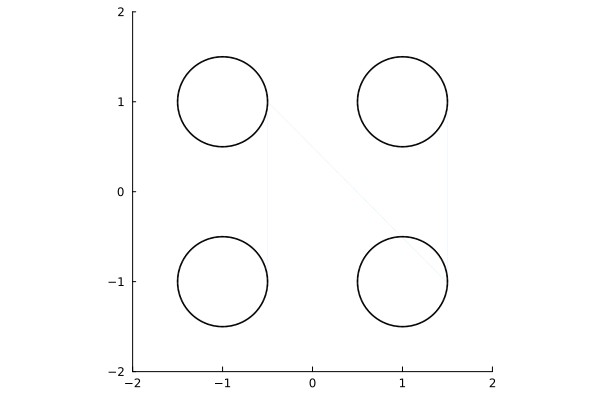

In [7]:
cache = SurfaceScalarCache(bl,g,scaling=GridScaling)
plot(cache,xlims=(-2,2),ylims=(-2,2))

## Body-by-body calculations
We can now perform operations on data that exploit the division into
distinct bodies. For example, let's compute the integral of $\mathbf{x}\cdot\mathbf{n}$,
for body 3. For any of the bodies, this integral should be approximately equal to the
area enclosed by the body (or volume in 3-d), multiplied by 2 (or 3 in 3-d).
For a circle of radius $1/2$, this area is $\pi/4$, so we expect the result
to be nearly $\pi/2$. We use the `pointwise_dot` operation in
`CartesianGrids.jl` to perform the dot product at each point.

In [8]:
pts = points(cache)
nrm = normals(cache)
V3 = integrate(pointwise_dot(pts,nrm),cache,3)

1.5708993266236522

We can also integrate `VectorData` over individual bodies, and the result
is simply a vector with the integral in each coordinate direction. Let's
demonstrate on another geometric integral, this time of $(\mathbf{x}\cdot\mathbf{x})\mathbf{n}$,
This integral, when divided by the enclosed area (volume) of the body,
is equal to the centroid of the body. Let's demonstrate on body 3, which
we expect to be centered at (-1,1)

In [9]:
Xc = integrate(pointwise_dot(pts,pts)∘nrm,cache,3)/V3

2-element Vector{Float64}:
 -1.0000000000000002
  1.0

Other operations we can perform body-by-body are `dot` and `norm`

## Copying data body by body
It is common that we will want to assign values to surface data, one body
at a time. For this, we can make use of an extension of the `copyto!` function.
Let's see some examples. Suppose we wish to set the value of a surface
scalar `u` to the $x$ component of the normal vectors for points on body 3, but
leave the values zero for all other bodies. Then we just do the following:

In [10]:
u = zeros_surface(cache)
copyto!(u,nrm.u,cache,3)
nothing #hide

Let's plot the data to verify this worked

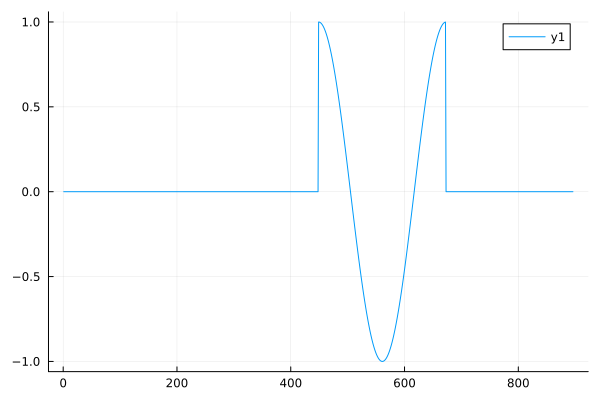

In [11]:
plot(u)

We can also plot just the data on body 3 (versus the arclength)

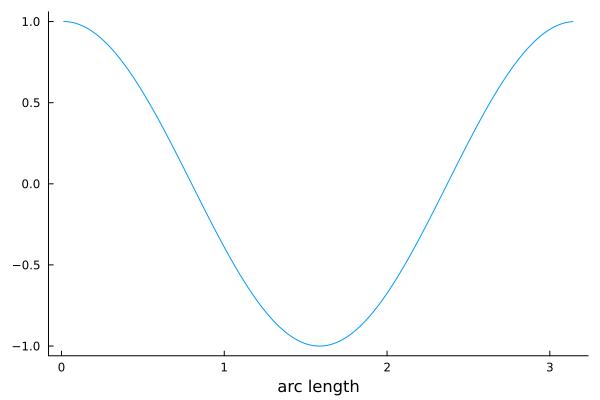

In [12]:
plot(u,cache,bodyid=3,xlabel="arc length")

It is also possible to use `copyto!` to copy a vector of just the right
size of the subarray associated with the body.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*